## Notebook 03

### **1. Why Backpropagation?**

So far, we’ve seen how to **manually implement a forward pass** through a neural network — we compute the prediction $\hat{y}$ by passing the input $\mathbf{x}$ through weighted layers.

But to make the model learn, we need something more:  
We need to **adjust the weights** so that predictions get better over time.

That’s where **backpropagation** comes in.

**What is Backpropagation?**

> Backpropagation is the algorithm used to **compute the gradients** of a loss function with respect to all weights and biases in the network.

**Why Gradients?**

- Gradients tell us **how much to change each parameter** to reduce the loss.
- These are computed using the **chain rule** from calculus.

**Understanding Backpropagation Flow**

The diagram below illustrates the **forward and backward passes** in a feedforward neural network with:

- 1 hidden layer (ReLU activation)  
- 1 output layer (Sigmoid activation)  
- A scalar loss $L$

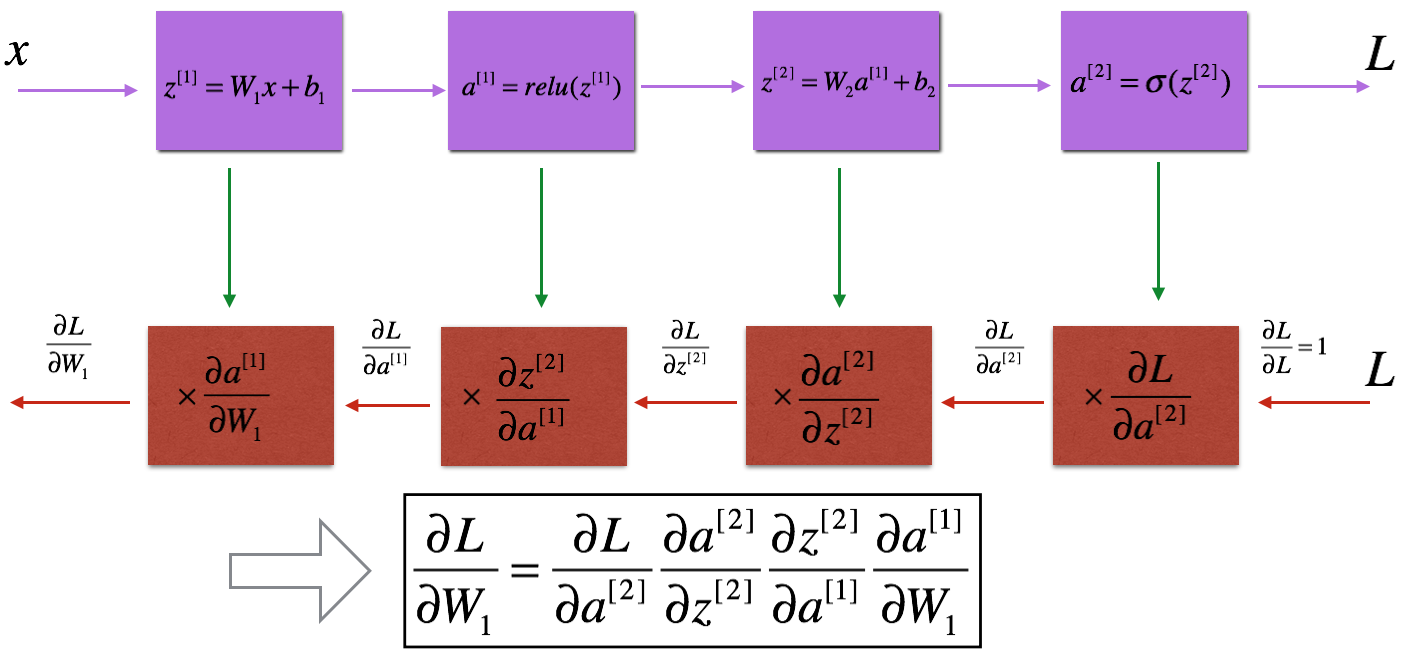

[source: https://pylessons.com/Deep-neural-networks-part3]

**Forward Pass (Purple Blocks)**

From left to right, the input $\mathbf{x}$ is transformed step by step:

1. **Hidden Layer (Linear)**  
   $$
   z^{[1]} = \mathbf{W}_1 \mathbf{x} + \mathbf{b}_1
   $$

2. **Activation (ReLU)**  
   $$
   a^{[1]} = \text{ReLU}(z^{[1]})
   $$

3. **Output Layer (Linear)**  
   $$
   z^{[2]} = \mathbf{W}_2 a^{[1]} + \mathbf{b}_2
   $$

4. **Activation (Sigmoid)**  
   $$
   \hat{y} = a^{[2]} = \sigma(z^{[2]})
   $$

Finally, we compute the **loss** $L(y, \hat{y})$ — often binary cross-entropy.


**Backward Pass (Brown Blocks)**

Backpropagation starts from the loss and flows backward using the **chain rule**.  
At each step, we compute gradients:

- $\frac{\partial L}{\partial a^{[2]}}$, then  
- $\frac{\partial L}{\partial z^{[2]}}$, then  
- $\frac{\partial L}{\partial a^{[1]}}$, and so on...

Each red box represents a **partial derivative**, and the arrows represent **chaining gradients** together using multiplication.


**Gradient of Loss with Respect to $\mathbf{W}_1$**

At the bottom, we summarize the final gradient needed to update the first layer’s weights:

$$
\frac{\partial L}{\partial \mathbf{W}_1} = 
\frac{\partial L}{\partial a^{[2]}} \cdot
\frac{\partial a^{[2]}}{\partial z^{[2]}} \cdot
\frac{\partial z^{[2]}}{\partial a^{[1]}} \cdot
\frac{\partial a^{[1]}}{\partial \mathbf{W}_1}
$$

Each component corresponds to one stage in the network,  
and their multiplication gives us the full gradient we need.

### 🧩 Key Learning Point

> **Backpropagation** breaks down a complex gradient into small, manageable steps — each one following the **chain rule**.

This is what allows us to **train deep neural networks efficiently**  
without computing complex symbolic derivatives from scratch.

### 📘 Notation Guide (Used Throughout This Notebook)

To keep our equations and code aligned, we will consistently use the following notation for our neural network:

- **$x$**: Input vector  
- **$z_1 = xW_1 + b_1$**: Linear output of the hidden layer (before activation)  
- **$a_1 = \phi(z_1)$**: Activation output of the hidden layer (e.g., ReLU or Sigmoid)  
- **$z_2 = a_1 W_2 + b_2$**: Linear output of the final (output) layer  
- **$\hat{y} = \sigma(z_2)$**: Final prediction after sigmoid activation  
- **$L$**: Loss comparing prediction $\hat{y}$ to the true label $y$

This structured notation helps us clearly follow both the **forward pass** and the **backward pass** during training and debugging.

> 💡 **Tip:** Each $z$ is a linear combination, and each $a$ is the result of applying a non-linear activation.


**Our Goal**

We want to **derive** and **implement** the following:

- $\frac{\partial L}{\partial W_2}$, $\frac{\partial L}{\partial b_2}$  
- $\frac{\partial L}{\partial W_1}$, $\frac{\partial L}{\partial b_1}$  

Then use these to **update the parameters** step-by-step.

**What We’ll Build**

- A simple **feedforward network** with:
  - 2 input units
  - 3 hidden neurons (ReLU or Sigmoid)
  - 1 output neuron (Sigmoid)
- A **manual backpropagation** engine using NumPy
- Training loop with **manual weight updates**
- Visualizations of loss and decision boundary
- Final real-world demo using **heart disease data**

> - By the end, you’ll have built your own gradient engine — no autograd!

➡️ Let’s begin by recalling the forward pass from last time.

---

### **2. Forward Pass Recap — NumPy Implementation**

Before we compute gradients, let’s quickly **rebuild the forward pass** of a simple feedforward network —  
the same one we saw in **Notebook 2**.

We’ll use:

- **Input dimension**: 2 (e.g., a sample $\mathbf{x} = [x_1, x_2]$)  
- **Hidden layer**: 3 neurons  
- **Output layer**: 1 neuron  
- **Activation**: ReLU (for simplicity — easy to derive later)

**Forward flow**:

1. **Compute hidden layer pre-activation**:

$$
\mathbf{z}_1 = \mathbf{x} W_1 + \mathbf{b}_1
$$

2. **Apply activation**:

$$
\mathbf{h} = \phi(\mathbf{z}_1)
$$

3. **Compute output**:

$$
\hat{y} = \mathbf{h} W_2 + b_2
$$

Where:

- $\phi$ = ReLU or sigmoid  
- **Shapes**:  
  - $\mathbf{x} \in \mathbb{R}^{1 \times 2}$  
  - $W_1 \in \mathbb{R}^{2 \times 3}$  
  - $W_2 \in \mathbb{R}^{3 \times 1}$

**Schematic Overview (Flow Diagram)**

```text
Input x (1×2)
     ↓
Linear: z₁ = x @ W₁ + b₁   → shape (1×3)
     ↓
Non-linearity: ReLU(z₁)    → h (1×3)
     ↓
Linear: ŷ = h @ W₂ + b₂    → shape (1×1)
     ↓
Output ŷ (prediction)
```

**Forward Pass with ReLU**

In [12]:
import numpy as np

# Input sample (batch size = 1)
x = np.array([[1.5, -0.5]])  # shape (1, 2)

# Manual initialization
np.random.seed(42)
W1 = np.random.randn(2, 3)
b1 = np.random.randn(1, 3)
W2 = np.random.randn(3, 1)
b2 = np.random.randn(1, 1)

# ReLU activation
def relu(z):
    return np.maximum(0, z)

# Sigmoid activation
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Forward pass
z1 = np.dot(x, W1) + b1      # (1, 3)
h = relu(z1)                 # (1, 3)
y_hat = np.dot(h, W2) + b2   # (1, 1)

# Output
print("Input x:", x)
print("Hidden activation h:", h)
print("Predicted output y_hat:", y_hat)

Input x: [[ 1.5 -0.5]]
Hidden activation h: [[1.56276912 0.67711496 0.6191269 ]]
Predicted output y_hat: [[0.48772548]]


**Summary**

We now have a clean **forward computation** through:

- A hidden layer with nonlinear activation  
- A final linear output neuron  

This structure is what we’ll now differentiate in the next section — using the **chain rule** to compute gradients.

➡️ Let’s now walk through the math for backpropagation and derive symbolic gradients for all parameters.

---

### **3. Deriving Gradients Manually (Backprop Step-by-Step)**

Now that we’ve built the forward pass, let’s understand **how to compute gradients** for each parameter so that we can **update weights** and improve predictions.

**Goal: Learn via Gradient Descent**

We want to **minimize a loss function**, e.g., Mean Squared Error (MSE):

$$
\mathcal{L} = \frac{1}{2}(\hat{y} - y)^2
$$

**Parameter Update Rule (Gradient Descent)**

When we train a neural network, we **adjust the parameters** to minimize the loss.

The general update rule is:

$$
\theta \leftarrow \theta - \eta \cdot \frac{\partial \mathcal{L}}{\partial \theta}
$$

Where:

- $\theta$: a parameter (e.g., a weight or bias)  
- $\eta$: learning rate (a small positive scalar)  
- $\frac{\partial \mathcal{L}}{\partial \theta}$: the gradient of the loss with respect to that parameter

**Why This Makes Sense**

At first glance, it may seem like we’re subtracting a **parameter** and a **slope** — but this is valid because:

- Both $\theta$ and $\frac{\partial \mathcal{L}}{\partial \theta}$ are of the **same shape** (scalar, vector, or matrix)  
- The gradient tells us the **direction and strength** of change needed  
- The learning rate $\eta$ controls how big a step we take

> 💡 **Think of it as:**  
> *“Take a small step in the direction that reduces the loss.”*

**🏔️Analogy: Gradient Descent as a Hike**

Imagine you're hiking on a hill:

- Your **current position** is $\theta$  
- The **slope of the hill** is the gradient  
- You want to go **downhill** to reach the **lowest point** (minimum loss)

So you take a step:

$$
\text{New position} = \text{Current position} - \text{step size} \times \text{slope}
$$

That’s all this formula is doing!

---

**📌 Note on Loss Function: When to Use**

The loss function:

$$
L = \frac{1}{2}(\hat{y} - y)^2
$$

is called **mean squared error (MSE)** and is commonly used for **regression tasks**, where the target $y$ is a **continuous number**.

✅ **Use this** when predicting **numerical values** (e.g., price, temperature, etc.)

- The $\frac{1}{2}$ is optional — it simplifies the derivative when doing backpropagation manually.


❗️ **Do NOT use this** for **binary classification** tasks (like disease vs. no disease).

➡️ For binary classification, we use:
- A **sigmoid** activation at the output
- A **binary cross-entropy** loss function:

$$
L = -[y \log(\hat{y}) + (1 - y)\log(1 - \hat{y})]
$$

This gives us **probabilities** and a more appropriate **loss surface** for classification tasks.

---


**Chain Rule in Action**

Our network is:

```text
x → z₁ = xW₁ + b₁ → h = ReLU(z₁) → ŷ = hW₂ + b₂ → L = ½(ŷ - y)²
```

We apply the **chain rule** to compute gradients backwards.


### Gradients for Output Layer

1. Derivative of loss w.r.t. prediction:

$$
\frac{\partial \mathcal{L}}{\partial \hat{y}} = \hat{y} - y
$$

2. Gradients for output weights $W_2$ and bias $b_2$:

$$
\frac{\partial \mathcal{L}}{\partial W_2} = (\hat{y} - y) \cdot \mathbf{h}^\top
$$

$$
\frac{\partial \mathcal{L}}{\partial b_2} = \hat{y} - y
$$


**Gradients for Hidden Layer**

Let’s go backward into the hidden layer:

3. Derivative w.r.t. hidden layer activation:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{h}} = (\hat{y} - y) \cdot W_2^\top
$$

4. If we used **ReLU** activation:

$$
\frac{\partial \mathbf{h}}{\partial \mathbf{z}_1} =
\begin{cases}
1 & \text{if } z_1 > 0 \\
0 & \text{otherwise}
\end{cases}
$$

So:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{z}_1} = \frac{\partial \mathcal{L}}{\partial \mathbf{h}} \circ \text{ReLU}'(\mathbf{z}_1)
$$

($\circ$ means **element-wise multiplication**)

5. Gradients for first layer weights $W_1$ and bias $b_1$:

$$
\frac{\partial \mathcal{L}}{\partial W_1} = \mathbf{x}^\top \cdot \frac{\partial \mathcal{L}}{\partial \mathbf{z}_1}
$$

$$
\frac{\partial \mathcal{L}}{\partial b_1} = \frac{\partial \mathcal{L}}{\partial \mathbf{z}_1}
$$


This is the full **manual backpropagation** logic for a 2-layer feedforward neural network.

➡️ **Next**, we’ll translate this math into **NumPy code** and verify if it works!

---

### **4. Implementing Backward Pass in NumPy**

Now that we’ve walked through all the gradient expressions,  
let’s **turn them into NumPy code** and update our network manually — no autograd involved.

We’ll use the **same 2→3→1 feedforward network** from earlier and add code to:

1. Compute loss  
2. Backpropagate gradients  
3. Update weights using gradient descent

**Setup: Forward + Backward in One Cell**

In [13]:
import numpy as np

# ===== Initialize a simple network =====
np.random.seed(42)

x = np.array([[2.0, -1.0]])   # single sample input (1, 2)
y = np.array([[1.0]])         # binary target

# Weights & biases
W1 = np.random.randn(2, 3)    # (input_dim, hidden_dim)
b1 = np.random.randn(1, 3)

W2 = np.random.randn(3, 1)    # (hidden_dim, output_dim)
b2 = np.random.randn(1, 1)

# ReLU and its derivative
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

# Forward pass
z1 = x @ W1 + b1             # Hidden linear
h = relu(z1)                 # Hidden activation
y_hat = h @ W2 + b2          # Output (no activation yet)

# Compute loss (MSE)
loss = 0.5 * (y_hat - y)**2

print("Prediction:", y_hat)
print("Loss:", loss)

Prediction: [[-0.018258]]
Loss: [[0.51842468]]


**Now Let’s Add Backward Pass**

In [14]:
# Backward pass
# Derivative of loss w.r.t. prediction
dL_dyhat = y_hat - y     # shape (1, 1)

# Gradients for output layer
dL_dW2 = h.T @ dL_dyhat  # (3, 1)
dL_db2 = dL_dyhat        # (1, 1)

# Gradient flowing into hidden layer
dL_dh = dL_dyhat @ W2.T              # shape (1, 3)
dL_dz1 = dL_dh * relu_derivative(z1) # shape (1, 3)

# Gradients for first layer
dL_dW1 = x.T @ dL_dz1     # (2, 3)
dL_db1 = dL_dz1           # (1, 3)

**Gradient Check**

Let’s print the gradients to verify the shapes and values:

In [15]:
print("Grad W2:", dL_dW2)
print("Grad b2:", dL_db2)
print("Grad W1:", dL_dW1)
print("Grad b1:", dL_db1)

Grad W2: [[-1.06877507]
 [-0.73829764]
 [-1.07939385]]
Grad b2: [[-1.018258]]
Grad W1: [[-1.10493221  0.94375755  0.94846609]
 [ 0.5524661  -0.47187877 -0.47423305]]
Grad b1: [[-0.5524661   0.47187877  0.47423305]]


**Parameter Update**

We’ll now do **one step of SGD (Stochastic Gradient Descent):**

In [16]:
# Learning rate
lr = 0.01

# Gradient descent update
W2 -= lr * dL_dW2
b2 -= lr * dL_db2
W1 -= lr * dL_dW1
b1 -= lr * dL_db1

That’s it! You’ve now manually implemented the full backward pass and parameter update.

> 🔁 In the next section, we’ll **wrap this into a loop**, so the network can **learn over multiple epochs**!

---

### **5. Manual Training Over Epochs (Stochastic Gradient Descent)**

We’ve now implemented:

- The **forward pass**
- The **backward pass**
- The **parameter update**

Now let’s **put it all inside a training loop**,  
so our perceptron network can gradually learn over multiple epochs!

**What Will Happen in Each Epoch?**

For each iteration (epoch), we’ll:

1. **Forward pass**: Compute predicted output \( \hat{y} \)
2. **Compute loss**: Using MSE
3. **Backward pass**: Calculate gradients
4. **SGD update**: Apply weight/bias updates
5. **Store loss**: For later visualization

**Manual Training Loop**

In [23]:
# Initialize weights and biases again (reset)
np.random.seed(42)

x = np.array([[1.0, -1.0]])
y = np.array([[1.0]])

W1 = np.random.randn(2, 3)
b1 = np.random.randn(1, 3)
W2 = np.random.randn(3, 1)
b2 = np.random.randn(1, 1)

# Hyperparameters
lr = 0.1
epochs = 10
losses = []

# Training loop
for epoch in range(epochs):
    # ----- Forward pass -----
    z1 = x @ W1 + b1
    h = relu(z1)
    y_hat = h @ W2 + b2
    loss = 0.5 * (y_hat - y)**2
    losses.append(loss.item())

    # ----- Backward pass -----
    dL_dyhat = y_hat - y
    dL_dW2 = h.T @ dL_dyhat
    dL_db2 = dL_dyhat

    dL_dh = dL_dyhat @ W2.T
    dL_dz1 = dL_dh * relu_derivative(z1)
    dL_dW1 = x.T @ dL_dz1
    dL_db1 = dL_dz1
    

    # ----- Parameter update -----
    W2 -= lr * dL_dW2
    b2 -= lr * dL_db2
    W1 -= lr * dL_dW1
    b1 -= lr * dL_db1

    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

Epoch 1: Loss = 0.5514
Epoch 2: Loss = 0.1787
Epoch 3: Loss = 0.0611
Epoch 4: Loss = 0.0203
Epoch 5: Loss = 0.0065
Epoch 6: Loss = 0.0020
Epoch 7: Loss = 0.0006
Epoch 8: Loss = 0.0002
Epoch 9: Loss = 0.0001
Epoch 10: Loss = 0.0000


✅ This is a **barebones training loop**, but it reflects what most optimizers in PyTorch/TensorFlow are doing internally.

Next, let’s **visualize how the loss changes over time** to confirm that learning is happening!

---

### **6. Visualizing Training Loss Curve**

Tracking the loss over epochs helps us answer key questions:

- Is the model **learning**?
- Is the learning **stabilizing**?
- Is it getting **stuck or diverging**?

Let’s visualize the loss we stored during training.

**Expected Behavior**

- Loss should **decrease steadily**.
- If loss is flat or bouncing, learning rate might be too high or low.
- Sudden spikes may suggest unstable gradients.

**Plot the Loss Over Epochs**

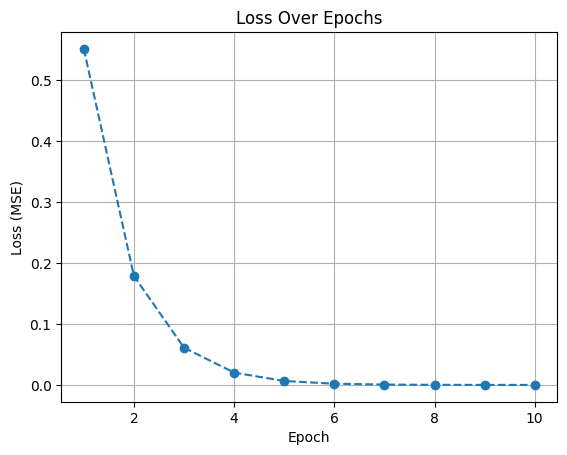

In [24]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), losses, marker='o', linestyle='--')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.grid(True)
plt.show()

✅ We’re using Mean Squared Error (MSE), so values should trend downwards.

Next, let’s **visualize the decision boundary** to see how the model is shaping the input space!  
This will give us intuition about how the network is learning to separate the classes.

### **7. Visualizing Learning on a Single Point**


Now that we’ve trained our small neural network using **manual backpropagation**,  
let’s **visualize how the model’s prediction evolves** over training.

Since we only used **one data point**, we can’t draw a full decision boundary.  
But we can still **track the predicted output (ŷ)** over epochs to understand what the model is learning.

**What We Expect**

Remember:

- Our target is \( y = 1 \)
- The model started with random weights and likely predicted something far from 1.
- Over time, the prediction \( \hat{y} \) should **approach 1**, reducing the loss.

**What We’re Plotting**

- The **output** of the model after each epoch  
- This shows **how quickly and accurately** the network learns the correct value

**Plot Output Prediction over Epochs**

In [25]:
# Assuming we stored model predictions per epoch (let's simulate it now)

predictions = []

# Re-run training loop (same as Section 5) but store predictions

# Reset weights
np.random.seed(42)
W1 = np.random.randn(2, 3)
b1 = np.random.randn(1, 3)
W2 = np.random.randn(3, 1)
b2 = np.random.randn(1, 1)

# Hyperparameters
lr = 0.1
epochs = 10
losses = []
predictions = []

# Input and target
x = np.array([[2.0, -1.0]])
y = np.array([[1.0]])

for epoch in range(epochs):
    # Forward pass
    z1 = x @ W1 + b1
    h = relu(z1)
    y_hat = h @ W2 + b2
    loss = 0.5 * (y_hat - y)**2

    losses.append(loss.item())
    predictions.append(y_hat.item())

    # Backward pass
    dL_dyhat = y_hat - y
    dL_dW2 = h.T @ dL_dyhat
    dL_db2 = dL_dyhat

    dL_dh = dL_dyhat @ W2.T
    dL_dz1 = dL_dh * relu_derivative(z1)
    dL_dW1 = x.T @ dL_dz1
    dL_db1 = dL_dz1

    # Update
    W2 -= lr * dL_dW2
    b2 -= lr * dL_db2
    W1 -= lr * dL_dW1
    b1 -= lr * dL_db1

**Tracking Prediction for One Input Over Time**

```text
Input x = [x₁, x₂]     ← fixed sample (e.g., [2.0, -1.0])
        │
        ▼
Hidden Layer: Linear → ReLU
  z₁ = x · W₁ + b₁
  h = ReLU(z₁)
        │
        ▼
Output Layer: Linear → (optional) Sigmoid
  z₂ = h · W₂ + b₂
  ŷ = z₂  (or sigmoid(z₂))
        │
        ▼
Compare ŷ vs. y
        │
        ▼
Track prediction (ŷ) over epochs
        │
        ▼
Plot: ŷ vs. Epoch Number
```

**Output Trajectory Plot**

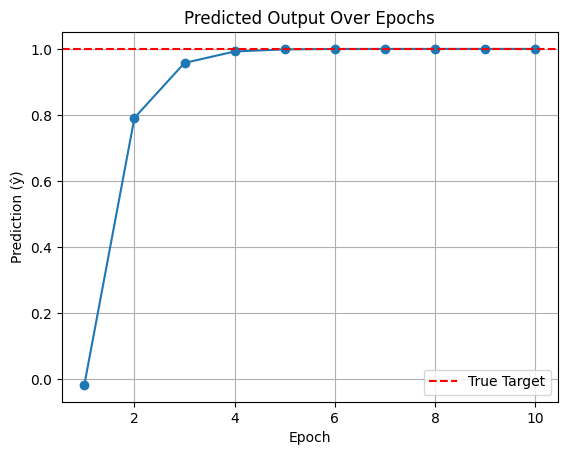

In [26]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), predictions, marker='o')
plt.title("Predicted Output Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Prediction (ŷ)")
plt.grid(True)
plt.axhline(y=1.0, color='r', linestyle='--', label='True Target')
plt.legend()
plt.show()

- The curve shows how quickly \( \hat{y} \) moves toward the correct value \( y = 1 \)
- A steady, smooth rise is a good sign: the model is **learning effectively**
- If the curve stagnates or oscillates, it could mean:
  - Learning rate is too high/low
  - Network capacity is insufficient
  - Vanishing gradients (in deeper nets)

> 🔔 **Reflection:**  
> Even with just one point, we’ve implemented **forward and backward passes** from scratch, showing how learning happens at a granular level.